<div style="font-size: 18pt;">RF, boosting and ROC</div><br/>

- Load KPI dataset<br/>
- Split into train/test data<br/>
- Train RF and one selected boosting ensemble models on train data set, use cross-validation<br/>
- Predict probabilities <br/>
- Use ROC curve to chose best threshold for each model<br/>


In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

ModuleNotFoundError: No module named 'xgboost'

#load and inspect KPI data
kpi = pd.read_csv("data/KPI_data_for_logit_model.csv")
kpi.columns

In [3]:
kpi = pd.read_csv('data/KPI_data_for_logit_model.csv')

In [4]:
#select columns that we will use
kpi = kpi[['KPI_assessment_1', 'Number.of.questionnaires_1', 'Average_grade_1', \
           'NPS_1', 'Additional_achievement_1', 'X502010_1']]
kpi.columns 

Index(['KPI_assessment_1', 'Number.of.questionnaires_1', 'Average_grade_1',
       'NPS_1', 'Additional_achievement_1', 'X502010_1'],
      dtype='object')

In [5]:
#prepare train and test sets
y502010 = kpi[['X502010_1']]
X = kpi.drop(['X502010_1'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(
    X, y502010, test_size=0.2, random_state=4, stratify=y502010)

#check proportions of 1s
y_train.mean(), y_test.mean()

(X502010_1    0.412338
 dtype: float64,
 X502010_1    0.415584
 dtype: float64)

In [6]:
#flatten vectors
y_train = y_train['X502010_1'].ravel()
y_test = y_test['X502010_1'].ravel()

In [10]:
#use random forest to forecast, calculate test set accuracy
rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, random_state=1234)
rf = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("RF accuracy:",metrics.accuracy_score(y_test, y_pred))

RF accuracy: 0.7532467532467533


In [16]:
#cross-validate random forest, choose parameters and describe them in the presentations
rf = RandomForestClassifier(random_state=1234)

params = {
    'max_leaf_nodes': [10, 20, 30, 40, 50],
    'n_estimators': [10, 20, 30, 50, 100, 200],
    'ccp_alpha': [0, 0.01, 0.1],
    'max_depth': [3,4,5,6]
}    

#check documentation 
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x_train, y_train)
grid_search.best_score_
rf_best = grid_search.best_estimator_
rf_best

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


RandomForestClassifier(ccp_alpha=0, max_depth=4, max_leaf_nodes=20,
                       n_estimators=50, random_state=1234)

In [18]:
#calculate cross-validated model accuracy and calculate probabilities
#remember method ".predict_proba" returns two columns we use the second one
y_pred = rf_best.predict(x_test)
print("RandomForest accuracy:",metrics.accuracy_score(y_test, y_pred))

RandomForest accuracy: 0.7142857142857143


In [20]:
y_prob = rf_best.predict_proba(x_test)

In [23]:
y_prob = y_prob[:,1]
y_prob.shape

(77,)

In [24]:
#get tpr, fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
str_thresholds = [str(round(x,2)) for x in thresholds]
# print(fpr, '\n', tpr, '\n', str_thresholds)

In [25]:
#change every second threshold to dot
sel = list(range(len(str_thresholds))[::2])
for ind in sel:
    str_thresholds[ind] = '.'
print(str_thresholds)

['.', '0.85', '.', '0.79', '.', '0.78', '.', '0.73', '.', '0.72', '.', '0.67', '.', '0.63', '.', '0.62', '.', '0.59', '.', '0.58', '.', '0.5', '.', '0.33', '.', '0.29', '.', '0.12', '.', '0.05', '.', '0.04', '.', '0.03']


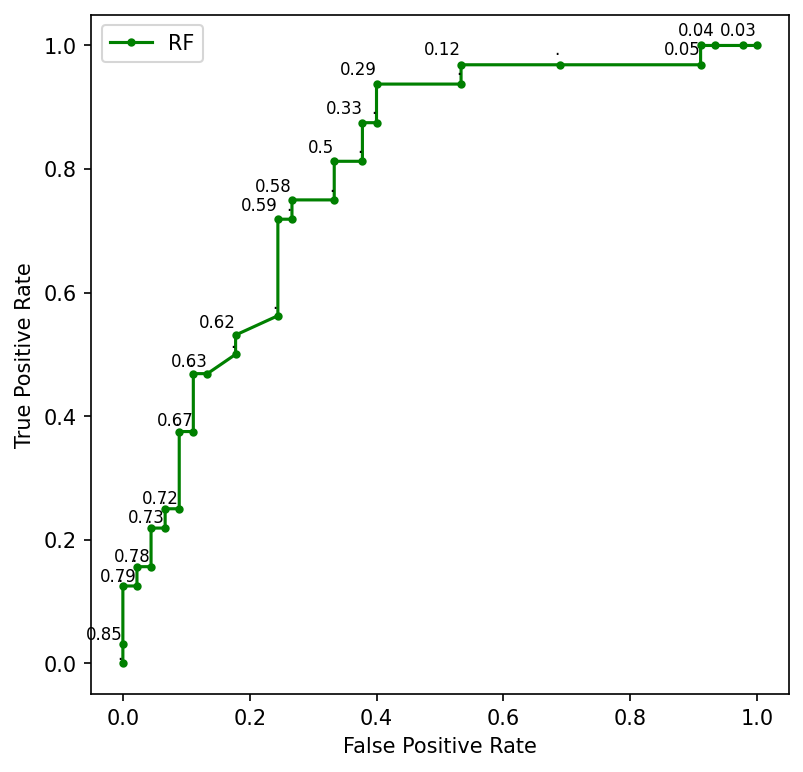

In [54]:
# plot the roc curve for the model
plt.figure(dpi=150, figsize=(6, 6))
plt.plot(fpr, tpr, marker='.', label='RF', c='green')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

for i in range(len(thresholds)): 
    plt.text(fpr[i], tpr[i]*1.01, str_thresholds[i], fontsize=8, va='bottom', ha='right')

plt.show()

In [55]:
roc_auc_score(y_test, y_prob)

0.7947916666666667

In [173]:
#define function for checking different threshold values (see lab 3)
import seaborn as sns
############################################################
def calculate_confusion_matrix(y_test, y_prob, threshold):
    y_pred_t = 1*(y_prob >= threshold)
    cfm = pd.crosstab(y_test, y_pred_t, rownames=['Actual'], colnames=['Predicted'])
    cfm = cfm / cfm.sum().sum()
    sns.heatmap(cfm, annot=True)
    accuracy = cfm.iloc[0,0] + cfm.iloc[1,1]
    print("`Accuracy =  {:6.4f}".format(accuracy))
    return cfm, accuracy
############################################################

`Accuracy =  0.7403


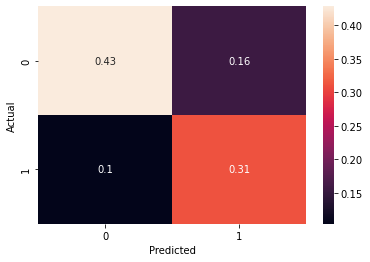

In [128]:
#try different thresholds, comment on changes in confussion matrix
cfm , accuracy = calculate_confusion_matrix(y_test, y_prob, 0.58)

In [122]:
cfm

Predicted         0         1
Actual                       
0          0.428571  0.155844
1          0.103896  0.311688

In [133]:
#try different thresholds, comment on changes in confussion matrix
acrcy = []
for t in thresholds[1:-1]:
    if t < 1:
        _, accuracy = calculate_confusion_matrix(y_test, y_prob, t)
        acrcy.append(accuracy)

`Accuracy =  0.5974
`Accuracy =  0.6364
`Accuracy =  0.6234
`Accuracy =  0.6364
`Accuracy =  0.6234
`Accuracy =  0.6494
`Accuracy =  0.6364
`Accuracy =  0.6494
`Accuracy =  0.6364
`Accuracy =  0.6883
`Accuracy =  0.6753
`Accuracy =  0.7143
`Accuracy =  0.7013
`Accuracy =  0.6883
`Accuracy =  0.7013
`Accuracy =  0.6753
`Accuracy =  0.7403
`Accuracy =  0.7273
`Accuracy =  0.7403
`Accuracy =  0.7013
`Accuracy =  0.7273
`Accuracy =  0.7013
`Accuracy =  0.7273
`Accuracy =  0.7143
`Accuracy =  0.7403
`Accuracy =  0.6623
`Accuracy =  0.6753
`Accuracy =  0.5844
`Accuracy =  0.4545
`Accuracy =  0.4675
`Accuracy =  0.4545
`Accuracy =  0.4286


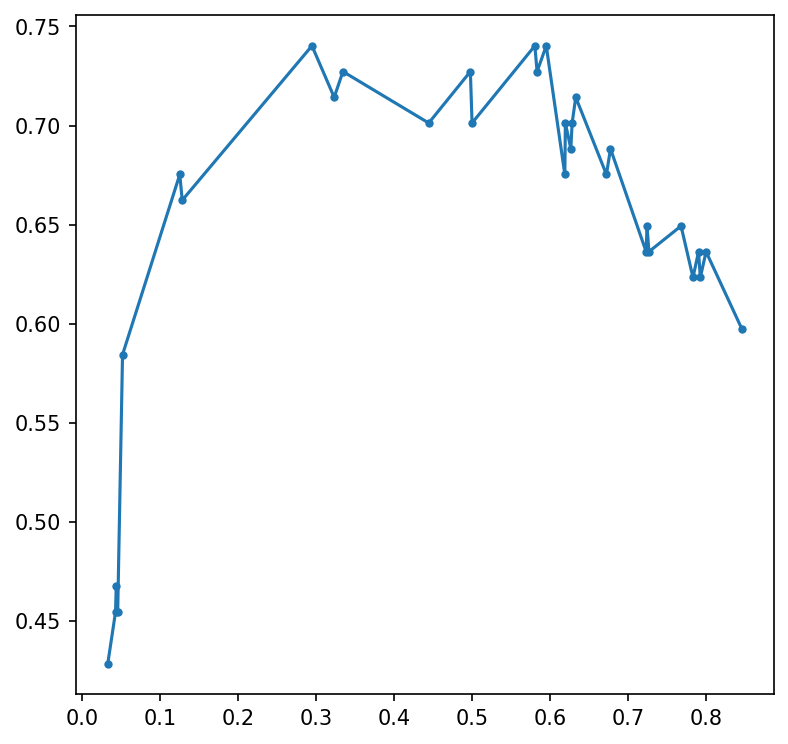

In [137]:
#try different thresholds, comment on changes in confussion matrix

plt.figure(dpi=150, figsize=(6,6))
plt.plot(thresholds[1:-1], acrcy, marker='.')
imax = np.argmax(acrcy)
# print('Maximal accuracy: ', acrcy[imax], 'with threshold:', thresholds[imax])

In [ ]:
#repeat for one of the Boosting classifiers

In [162]:
#LGBM classifier
lgbm = lgb.LGBMClassifier(random_state=1234)

params = {
    'n_estimators': [50,100,200,300,400,500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3,4,5,6]
}


#check documentation 
grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x_train, y_train)
grid_search.best_score_
lgbm_best = grid_search.best_estimator_

lgbm = lgbm_best.fit(x_train,y_train)
y_pred = lgbm_best.predict(x_test)
print("LGBM accuracy:",metrics.accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
LGBM accuracy: 0.7142857142857143


In [163]:
#CatBoost classifier
cb=CatBoostClassifier(iterations=500, random_state=1234)
params = {
    'iterations': [50,100,200,300,400,500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3,4,5,6]
}


#check documentation 
grid_search = GridSearchCV(estimator=cb,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x_train, y_train)
grid_search.best_score_
cb_best = grid_search.best_estimator_

cb = cb_best.fit(x_train,y_train)
y_pred = cb_best.predict(x_test)
print("CB accuracy:",metrics.accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0:	learn: 0.6725652	total: 49.4ms	remaining: 2.42s
1:	learn: 0.6496134	total: 49.8ms	remaining: 1.2s
2:	learn: 0.6304200	total: 50.8ms	remaining: 796ms
3:	learn: 0.6165749	total: 51.3ms	remaining: 590ms
4:	learn: 0.6005926	total: 51.7ms	remaining: 465ms
5:	learn: 0.5888658	total: 52.1ms	remaining: 382ms
6:	learn: 0.5736481	total: 61.3ms	remaining: 377ms
7:	learn: 0.5617378	total: 61.7ms	remaining: 324ms
8:	learn: 0.5509573	total: 62.2ms	remaining: 283ms
9:	learn: 0.5428075	total: 62.6ms	remaining: 250ms
10:	learn: 0.5324141	total: 63ms	remaining: 223ms
11:	learn: 0.5251307	total: 63.5ms	remaining: 201ms
12:	learn: 0.5178883	total: 64.1ms	remaining: 183ms
13:	learn: 0.5103357	total: 64.5ms	remaining: 166ms
14:	learn: 0.5050066	total: 73ms	remaining: 170ms
15:	learn: 0.4979282	total: 73.3ms	remaining: 156ms
16:	learn: 0.4915258	total: 73.7ms	remaining: 143ms
17:	learn: 0.4879337	total: 74.2ms	remaining: 132ms
18:	learn: 0.4806

In [151]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=1234)
params = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.1, 0.001],
    'max_depth': [3, 4, 5, 6]
}    

#check documentation 
grid_search = GridSearchCV(estimator=gb,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x_train, y_train)
# grid_search.best_score_
gb_best = grid_search.best_estimator_
# gb_best

y_pred = gb_best.predict(x_test)
print("CV Gradient Boost accuracy:",metrics.accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CV Gradient Boost accuracy: 0.6753246753246753


In [164]:
y_prob = cb_best.predict_proba(x_test)

In [165]:
y_prob = y_prob[:,1]
y_prob.shape

(77,)

In [166]:
#get tpr, fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
str_thresholds = [str(round(x,2)) for x in thresholds]
# print(fpr, '\n', tpr, '\n', str_thresholds)

In [167]:
#change every second threshold to dot
sel = list(range(len(str_thresholds))[::2])
for ind in sel:
    str_thresholds[ind] = '.'
print(str_thresholds)

['.', '0.89', '.', '0.82', '.', '0.75', '.', '0.73', '.', '0.72', '.', '0.67', '.', '0.63', '.', '0.56', '.', '0.43', '.', '0.38', '.', '0.09', '.', '0.08', '.', '0.06', '.', '0.04', '.']


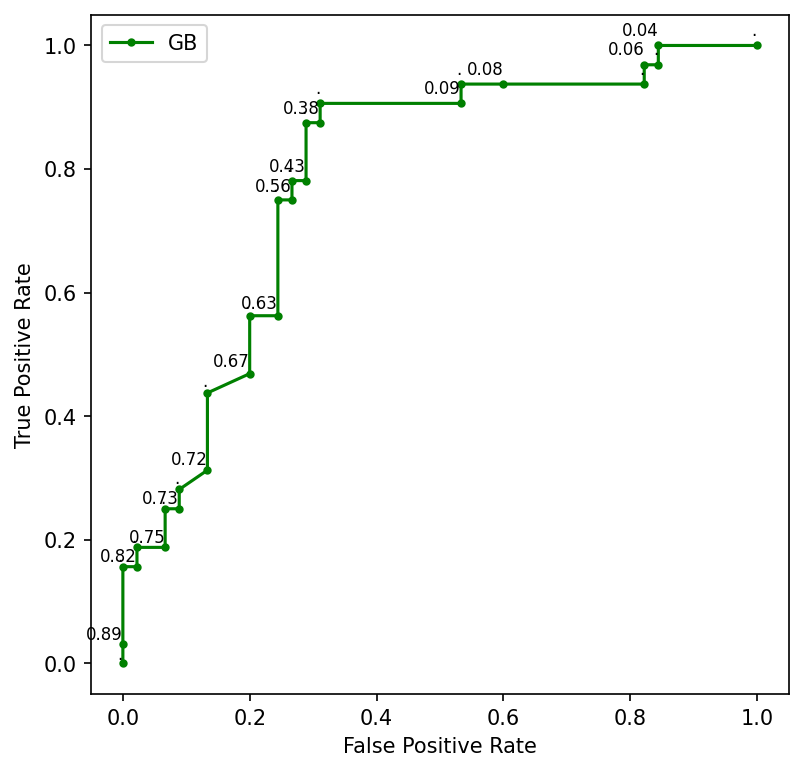

In [168]:
# plot the roc curve for the model
plt.figure(dpi=150, figsize=(6, 6))
plt.plot(fpr, tpr, marker='.', label='CB', c='green')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

for i in range(len(thresholds)): 
    plt.text(fpr[i], tpr[i]*1.01, str_thresholds[i], fontsize=8, va='bottom', ha='right')

plt.show()

In [169]:
roc_auc_score(y_test, y_prob)

0.7885416666666666

In [170]:
#try different thresholds, comment on changes in confussion matrix
acrcy = []
for t in thresholds[1:-1]:
    if t < 1:
        _, accuracy = calculate_confusion_matrix(y_test, y_prob, t)
        acrcy.append(accuracy)

`Accuracy =  0.5974
`Accuracy =  0.6494
`Accuracy =  0.6364
`Accuracy =  0.6494
`Accuracy =  0.6234
`Accuracy =  0.6494
`Accuracy =  0.6364
`Accuracy =  0.6494
`Accuracy =  0.6364
`Accuracy =  0.6883
`Accuracy =  0.6623
`Accuracy =  0.7013
`Accuracy =  0.6753
`Accuracy =  0.7532
`Accuracy =  0.7403
`Accuracy =  0.7532
`Accuracy =  0.7403
`Accuracy =  0.7792
`Accuracy =  0.7662
`Accuracy =  0.7792
`Accuracy =  0.6494
`Accuracy =  0.6623
`Accuracy =  0.6234
`Accuracy =  0.4935
`Accuracy =  0.5065
`Accuracy =  0.4935
`Accuracy =  0.5065


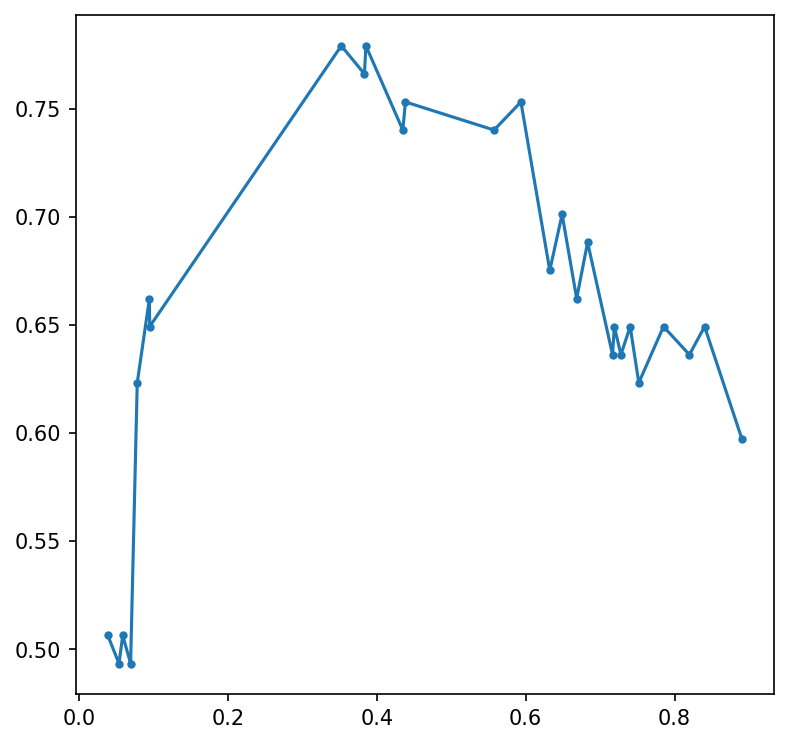

In [171]:
#try different thresholds, comment on changes in confussion matrix

plt.figure(dpi=150, figsize=(6,6))
plt.plot(thresholds[1:-1], acrcy, marker='.')
imax = np.argmax(acrcy)
# print('Maximal accuracy: ', acrcy[imax], 'with threshold:', thresholds[imax])

`Accuracy =  0.7662


(Predicted         0         1
 Actual                       
 0          0.402597  0.181818
 1          0.051948  0.363636,
 0.7662337662337663)

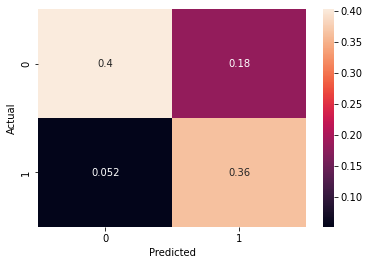

In [174]:
calculate_confusion_matrix(y_test, y_prob, 0.38)